# Canine Cutaneous Tumor Classification

## Import packages

In [1]:
import sys 
sys.path.insert(0, '..')
from fastai.utils.collect_env import show_install
from fastai.vision import *
from slide.slide_helper import SlideSegmentationItemList
from slide.process_slides import *
from fastai.callbacks.tracker import SaveModelCallback

## Label function

In [2]:
def get_y_func(x):
    label_dict = {7:'Melanoma', 8:'Plasmacytoma', 9:'Mast Cell Tumor', 10:'PNST', 11:'SCC', 12:'Trichoblastoma', 13:'Histiocytoma'}
    return label_dict[x.labels[0]]

## Confirm that you have a GPU up and running

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
show_install()



```text
=== Software === 
python        : 3.7.3
fastai        : 1.0.61
fastprogress  : 0.2.7
torch         : 1.6.0+cu101
nvidia driver : 442.83
torch cuda    : 10.1 / is available
torch cudnn   : 7604 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 4096MB | Quadro T1000
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.



## Define model parameters

In [4]:
patch_size = 256
patches_per_slide = 10 # define number of pathes sampled per slide for each pseudo-epoch
batch_size = 4
level = 0  # resolution level of image pyramid (higher level corresponds to lower resoution)
lr = 5e-3
encoder = models.xception(c=7)

## Define paths of slide folder and annotation JSON

In [5]:
target_folder = Path("E:/Slides/Canine Skin Tumors")
annotation_file = "E:/Slides/Canine Skin Tumors/skin_tumors.json"

## Define dict to match annotation classes used for training
> Label classes that shall be exluded from training with -1

In [6]:
label_dict = {'Bg': -1, 'Bone': -1, 'Cartilage': -1, 'Dermis': -1, 'Epidermis': -1, 'Subcutis': -1,'Inflamm/Necrosis': -1,'Melanoma': 0, 'Plasmacytoma': 1, 'Mast Cell Tumor': 2, 'PNST': 3, 'SCC': 4, 'Trichoblastoma': 5,'Histiocytoma': 6}

## Load slides using custom SlideContainer format and split into train, validation and test set

In [7]:
container = load_slides(patch_size,label_dict, level, target_folder,annotation_file = annotation_file, dataset_type='classification')
train_files, valid_files, test_files= train_val_test_split(container)
train_data = create_patches(train_files, patches_per_slide)
valid_data = create_patches(valid_files, patches_per_slide)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:32<00:00,  4.25s/it]


## Use standard [transforms](https://fastai1.fast.ai/vision.transform.html) for augmentation provided by fastai

In [8]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=45,
                      max_lighting=0.15, 
                      max_zoom=2)

## Create fastai databunch

In [9]:
train = SlideSegmentationItemList(train_data)
valid = SlideSegmentationItemList(valid_data)
path = Path('.')
item_list = ItemLists(path, train, valid)
item_list = item_list.label_from_func(get_y_func,classes=['Melanoma', 'Plasmacytoma','Mast Cell Tumor', 'PNST', 'SCC', 'Trichoblastoma', 'Histiocytoma'],label_cls=CategoryList)
#data = item_list.transform(tfms, size=patch_size).databunch(bs=batch_size).normalize()
data = item_list.transform(tfms, size=patch_size).databunch(bs=batch_size, num_workers=0).normalize() # For Windows set num_workers = 0
learn = Learner(data, encoder, metrics=accuracy,callback_fns=[ShowGraph])

## Let's have a look at the data

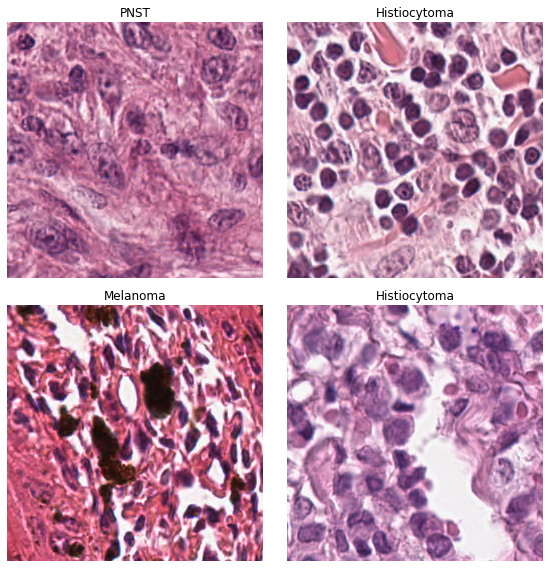

In [10]:
data.show_batch(ds_type=DatasetType.Valid)

## Initialize learner

In [11]:
learn = Learner(data, encoder, metrics=accuracy,callback_fns=[ShowGraph])

## Start training

epoch,train_loss,valid_loss,accuracy,time
0,1.991392,2.013482,0.191429,05:26
1,1.938176,1.995503,0.185714,05:02
2,1.946749,1.983064,0.174286,04:49
3,1.895408,1.898870,0.191429,04:50
4,1.857418,1.857405,0.197143,05:01


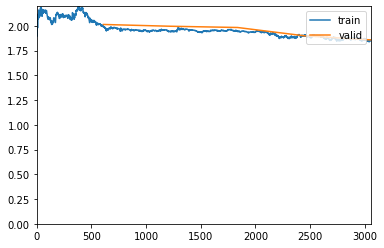

Better model found at epoch 0 with accuracy value: 0.19142857193946838.
Better model found at epoch 4 with accuracy value: 0.1971428543329239.


In [12]:
learn.fit_one_cycle(5, slice(lr), callbacks=SaveModelCallback(learn, every='improvement', monitor='accuracy',name='classification_learner'))

## Let's have a look at some results

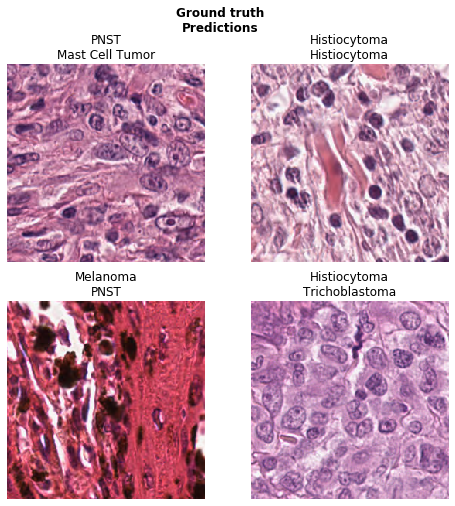

In [13]:
learn.show_results(ds_type=DatasetType.Valid)

## Export learner

In [14]:
learn.export('classification_learner.pkl')